In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

import PIL
import PIL.Image
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
import sys
sys.path.append('..')

from scr import train

In [3]:
images_path = '../data/dataset/dataset/training_data/images'

In [4]:
train_df = train.Train().get_annotation()
train_df = train_df[(train_df.label == 'other')&(train_df.text.str.contains('(^\d{5,10})|(\d{5,10}$)'))]
train_df

C:\Users\uriks\AppData\Local\Temp/ipykernel_4076/762169767.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  train_df = train_df[(train_df.label == 'other')&(train_df.text.str.contains('(^\d{5,10})|(\d{5,10}$)'))]


,box,text,label,words,linking,id,fil_name
8,"[525, 904, 641, 926]",597005708,other,"[{'box': [525, 904, 641, 926], 'text': '597005...",[],8,0000971160
29,"[533, 829, 653, 853]",620419245,other,"[{'box': [533, 829, 653, 853], 'text': '620419...",[],29,0000989556
32,"[72, 804, 111, 816]",05045,other,"[{'box': [72, 804, 111, 816], 'text': '05045'}]",[],32,0000989556
10,"[501, 839, 623, 871]",620429480,other,"[{'box': [501, 839, 623, 871], 'text': '620429...",[],10,0000990274
119,"[550, 883, 675, 904]",620915734,other,"[{'box': [550, 883, 675, 904], 'text': '620915...",[],119,0000999294
...,...,...,...,...,...,...,...
10,"[689, 797, 703, 870]",92657391,other,"[{'box': [689, 797, 703, 870], 'text': '926573...",[],10,92657391
31,"[683, 785, 698, 853]",93213298,other,"[{'box': [683, 785, 698, 853], 'text': '932132...",[],31,93213298
4,"[735, 799, 753, 870]",93329540,other,"[{'box': [735, 799, 753, 870], 'text': '933295...",[],4,93329540
11,"[716, 825, 736, 905]",93351929,other,"[{'box': [716, 825, 736, 905], 'text': '933519...",[],11,93351929_93351931


In [5]:
data = []
targets = []
filenames = []

sithe = 512

for name in train_df.fil_name.unique():
    filename = name + '.png'
    image_path = f'{images_path}/{filename}'
    image = cv2.imread(image_path)    
    (h, w) = image.shape[:2]
    
    row = train_df.loc[train_df.fil_name == name, 'box'].max()
    (startX, startY, endX, endY) = row
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    
    image = load_img(image_path, target_size=(sithe, sithe))
    image = img_to_array(image)
    
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)
# data, '\n', targets, '\n',  filenames
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


512 512
0.6889763779527559 0.904 0.8412073490813649 0.926
352.755905511811 462.848 77.94225721784778 11.26400000000001


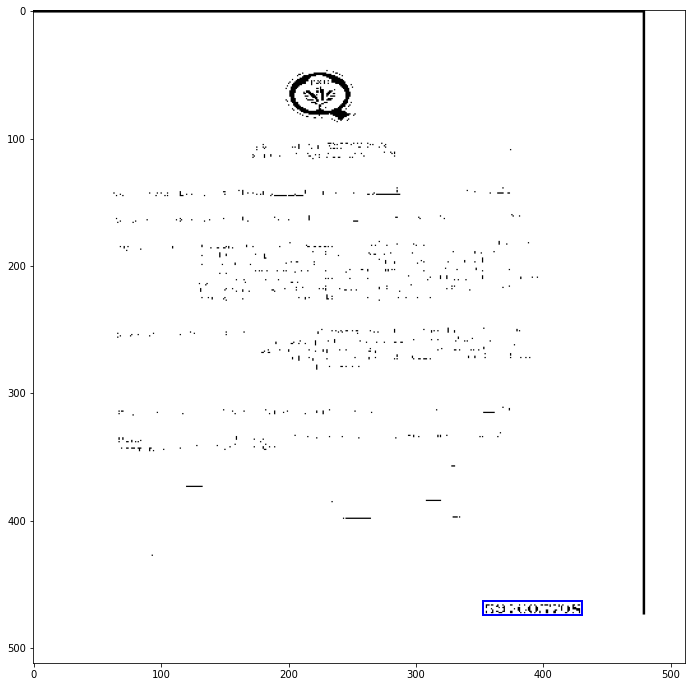

In [6]:
i = 0
fig,ax = plt.subplots(figsize=(12, 12))
plt.imshow(data[i], cmap="binary")
H, W, _ = data[i].shape
print(W, H)
startX, startY, endX, endY = targets[i]
print(startX, startY, endX, endY)
x = startX * W
y = startY * H
w = (endX - startX) * W
h = (endY - startY) * H

rect = patches.Rectangle((x, y), w , h, lw=2,
                                 ec ='b', facecolor='none')
print(x, y, w, h)
ax.add_patch(rect)
plt.show()

In [7]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [1]:
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(sithe, sithe, 3)))

NameError: name 'VGG16' is not defined

In [9]:
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)
bboxHead = Dense(256, activation="relu")(flatten)
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
model = Model(inputs=vgg.input, 
              outputs=bboxHead
             )

In [10]:
opt = Adam(
    learning_rate = 1e-4
)
model.compile(loss="mse", optimizer=opt)
# print(model.summary())

In [11]:
trainImages[0].shape

(512, 512, 3)

In [ ]:
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=64,
	epochs=6,
	verbose=1
)

[INFO] training bounding box regressor...
Epoch 1/6


In [ ]:
# model.save('../scr/segm_model')

In [ ]:
test_im_path = r'..\data\dataset\dataset\testing_data\images\83624198.png'
test_im = load_img(test_im_path, target_size=(sithe, sithe))
test_im = img_to_array(test_im) / 255.0
test_im = np.expand_dims(test_im, axis=0)

In [ ]:
print(test_im.shape)
preds = model.predict(test_im)
preds

In [ ]:
im = np.array(PIL.Image.open(test_im_path).convert("1"))
H, W = im.shape
fig,ax = plt.subplots(figsize=(12, 12))
plt.imshow(im, cmap="binary")
for lb in preds:
    print(lb)
    startX, startY, endX, endY = lb
    x = startX * W
    y = startY * H
    w = (endX - startX) * W
    h = (endY - startY) * H
    
    print(x, y, w, h)
    rect = patches.Rectangle((x, y), w, h, linewidth=1, lw = 2,
                             fc ='b', facecolor='none',alpha = 0.3)
    ax.add_patch(rect)
    rect = patches.Rectangle((x, y), w, h, lw=2,
                             ec ='b', facecolor='none')
    ax.add_patch(rect)
plt.show()
print(np.unique(im))